# 2022 Financial Quant Analyst Technical Interview Questions
Author: Mauricio Giliberto

In [1]:
import random
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import yfinance as yf

random.seed(9999)
np.random.seed(9999)

## Probability & Statistics & Monte Carlo Simulation

### Answer 1


 Under the assumption that the probability of each child's gender is 0.5 when they are born,
 
$$
    P(C_i=1) = P(C_i=0) = 0.5. \\
$$

We are looking to determine if the generation's rule of the children population (families having children until they have a girl) affects the hypothetical 0.5 proportion of the population without such a rule.  
We can formulate this as the following Hypothesis test:
- Null Hypothesis: the proportion of girls doesn't change with the generation rule. 
- Alternative hypothesis: as people want girls, there is a higher proportion of girls than boys.

$$ 
H_0: \pi = \pi_0 = 0.5 \\
H_a: \pi > \pi_0
$$

Let us define a class to analyze the problem:

In [2]:
class child_sample():

    def __init__(self, f=10):
        self.f = f # number of families
        self.sample = sum([self.family_gen() for _ in range(self.f)], []) # Repeat f times a family generator
        self.n = len(self.sample) # total number of children
        self.prop = sum(self.sample)/self.n # proportion of girls

    def family_gen(self, fam_list=None):
        # method to recursively generate children until a girl is born
        fam_list = [] if fam_list is None else fam_list
        if any(fam_list):
            return fam_list
        else:
            fam_list.append(random.randint(0, 1))
            return self.family_gen(fam_list)
            
    def describe(self):
        # summary sample
        desc_dict = {
            "f"     : self.f,
            "n"     : self.n,
            "prop"  : self.prop,
            "se"    : (self.prop*(1-self.prop)/self.n)**(1/2)
        }
        return desc_dict
    
    def test(self, test_prop=0.5):
        # proportion test
        se_0 = ((test_prop*(1-test_prop))/self.n)**(1/2)
        self.z = (self.prop - test_prop)/se_0
        self.p_value = 1 - sp.stats.norm(0, 1).cdf(self.z)
        desc_dict = {
            "stat" : self.z,
            "pval" : self.p_value
        }
        return desc_dict

The defined class contains a method to generate a family with the generation rule.
As we can see, the recursive method generates a list of 0's (boys) until a girl is born (1).

In [3]:
child_sample().family_gen()

[0, 1]

We repeat the generator f times, with f as the number of families simulated.
We can see an example of ten families generated with the method:

In [4]:
{"f" + str(i) : child_sample(1).family_gen() for i in range(10)}

{'f0': [1],
 'f1': [0, 1],
 'f2': [1],
 'f3': [1],
 'f4': [0, 1],
 'f5': [0, 0, 1],
 'f6': [0, 1],
 'f7': [1],
 'f8': [0, 0, 0, 1],
 'f9': [0, 0, 1]}

The class has one input argument, f, as the number of families generated for our sample. Let's set it as 1000.
So the class will generate a sample, and we can summarize it with the method describe().

In [5]:
f = 1000
a = child_sample(f)
a.describe()

{'f': 1000, 'n': 1968, 'prop': 0.508130081300813, 'se': 0.011269380365854459}

Our simulated sample got a proportion of girls equal to 0.508.
Let's proceed to evaluate our initial test,

In [6]:
a.test()

{'stat': 0.7213357077339497, 'pval': 0.2353514962557035}

### Answer 3 (Continuation of Answer 1)

The test statistic indicates how far the estimated proportion falls from the parameter value of $H_0$ expressed in the number of standard errors.
In this case, 0.72 standard errors are the difference between the obtained proportion and a hypothetical 0.5.
Then we ask whether this difference is statistically significant, in other words, how unusual would be to get this sample proportion under the presumption of the null hypothesis.
The p-value is the probability of getting the observed, or even a more extreme value, in the direction of the $H_a$ under the assumption of the Null hypothesis.
As the p-values is quite high (0.1, 0.05, or below are usually considered to be significant), we don't have enough evidence to reject the null hypothesis of a 0.5 proportion of girls. In other words, the sample proportion obtained with the simulation and the generator rule wouldn't be unusual for a population with a 0.5 proportion. 

Finally, we check the results with the statsmodels library, obtaining identical results.

In [7]:
stat, pval = proportions_ztest(
    count=sum(a.sample), 
    nobs=len(a.sample),
    value=0.5,
    alternative='larger',
    prop_var=False
)

print([stat, pval])

[0.7214310846625346, 0.23532216360732128]


### Answer 2

Linear regression is a statistical method to predict a quantitative response.
It assumes that exists a linear relationship between the variable we are interested to predict and a set of predictor variables.
In other words, we assume that there is a $\beta$ coefficient that describes the linear relation between the two (or more) variables considered.
This coefficient represents how a unitary change of the predictor variables affects the predicted variable. When $X_i$ (the variables used to predict) is increased by 1 unit, then the predicted response variable will increase $\beta_i$ times on average.
Usually, we don´t know $\beta_i$ coefficients, so we estimate them to get $\hat{\beta_i}$. The most popular method to estimate the coefficients is the least squared errors, which consists of minimizing the sum of squared errors, in other words, the sum of the squared differences between the estimated response variables by the method and the observed response variable.

### Answer 4

We proceed to analyze the problems with two methods:
- Using conditional probabilities properties
- Running a Monte Carlo simulation

#### Conditional probabilities

We are asked what is the probability of being raining in Newcastle given that all 3 of the friends said it is raining. We can formulate this as:

$$
P(R=1 | F_1 = 1, F_2 = 1, F_3 = 1)
$$

Which can be reformulated as:

$$
P(R=1 | \sum_{i=1}^{3} F_i = 3) = \dfrac{P(\sum_{i=1}^{3} F_i = 3)|R=1) P(R=1)}{P(\sum_{i=1}^{3} F_i = 3)} \\
P(\sum_{i=1}^{3} F_i = 3) = P(R=1) P(\sum_{i=1}^{3} F_i = 3 | R=1) + P(R=0) P(\sum_{i=1}^{3} F_i = 3|R=0)
$$

We know:

$$
P(\sum_{i=1}^{3} F_i = 3 | R=1) = (2/3)^3 \\
P(\sum_{i=1}^{3} F_i = 3 | R=0) = (1/3)^3 
$$

Finally, we get the expression:

$$
P(R=1 | \sum_{i=1}^{3} F_i = 3) = \dfrac{(2/3)^3 P(R=1)}{P(R=1) (2/3)^3 + (1-P(R=1)) (1/3)^3}
$$

We can see that the result will depend on missing data, which is the probability of being raining in Newcastle.
Let's evaluate a list of possible values for this probability:

In [8]:
p_a_list = [0, 0.25, 0.5, 0.75, 1]
{p_a: (2/3)**3 * p_a / (p_a * (2/3)**3 + (1-p_a) * (1/3)**3) for p_a in p_a_list}

{0: 0.0,
 0.25: 0.7272727272727272,
 0.5: 0.8888888888888888,
 0.75: 0.9600000000000001,
 1: 1.0}

#### Monte Carlo Simulation

Let's define a class to simulate the combination of multiple scenarios:

In [9]:
class rain_simul():
 
    def __init__(self, p=0.5, n=1000, f=3, t=2/3):
        self.p = p # rain prob
        self.n = n # number of simulations
        self.f = f # number of friends
        self.t = t # prob of saying true
        self.sample = [self.ind() for _ in range(self.n)]
       
    def ind(self):
        r = 1 if random.random() < self.p else 0 # is it raining?
        t = [ 1 if random.random() < self.t else 0 for _ in range(self.f)] # will friends say the truth
        return r, list(map(lambda x: 1 if (x and r) or (not x and not r) else 0 , t)) # return a tuple (R, [F1, F2, F3])

This is how the sample looks, a list of tuples with the first element indicating if it rains(1) or not(0), and a list of the responses for the three friends, with 1 for when they say it is raining and 0 when they say it is not.

In [10]:
rain_simul(n=10).sample

[(0, [0, 0, 1]),
 (0, [0, 1, 1]),
 (1, [0, 0, 1]),
 (1, [1, 1, 0]),
 (1, [1, 1, 1]),
 (0, [1, 0, 1]),
 (0, [0, 0, 0]),
 (0, [0, 1, 0]),
 (0, [1, 0, 0]),
 (0, [0, 0, 0])]

With the same probablities list, we proced to simulate 10000 times the posible response scenarios.
We summarize the simulation with crosstabs. The columns represent how many friends say that it is raining, while the rows indicates if it is actualy raining.

In [11]:
for p in p_a_list:

    s = rain_simul(p=p, n=10000).sample
    df = pd.DataFrame({"r": [i[0] for i in s], "f": [sum(i[1]) for i in s]})
    print("p="+str(p))
    print(pd.crosstab(df["r"], df["f"]), end = "\n"*2)

p=0
f     0     1     2    3
r                       
0  2993  4530  2099  378

p=0.25
f     0     1     2    3
r                       
0  2291  3265  1680  281
1    92   547  1096  748

p=0.5
f     0     1     2     3
r                        
0  1456  2212  1107   196
1   186  1139  2179  1525

p=0.75
f    0     1     2     3
r                       
0  794  1149   534    96
1  264  1702  3321  2140

p=1
f    0     1     2     3
r                       
1  359  2204  4479  2958



Dividing each of these absolute values by the total of each column will bring us the probability of being raining given how many friends said it is raining.

In [12]:
for p in p_a_list:

    s = rain_simul(p=p, n=10000).sample
    df = pd.DataFrame({"r": [i[0] for i in s], "f": [sum(i[1]) for i in s]})
    print("p="+str(p))
    print(pd.crosstab(df["r"], df["f"])/ pd.value_counts(df["f"]), end = "\n"*2)

p=0
     0    1    2    3
r                    
0  1.0  1.0  1.0  1.0

p=0.25
          0         1         2         3
r                                        
0  0.962289  0.850053  0.593426  0.287293
1  0.037711  0.149947  0.406574  0.712707

p=0.5
          0         1         2         3
r                                        
0  0.883841  0.652664  0.319976  0.110583
1  0.116159  0.347336  0.680024  0.889417

p=0.75
          0         1         2         3
r                                        
0  0.733583  0.398771  0.147528  0.039405
1  0.266417  0.601229  0.852472  0.960595

p=1
     0    1    2    3
r                    
1  1.0  1.0  1.0  1.0



We are interested in the bottom-right proportion (probability of being raining given that the three friends said it is raining).
As we can see, these values are quite similar to those obtained with the previous method. So the results are consistent with each other.

## Quantitative Finance

### Answer 5

As Microsoft and Apple are both technological companies highly correlated, the portfolio’s expected returns will be reduced, since on average the returns will show opposite signs, this means that while one position generates a positive return, the other one will generate a negative one and vice versa, and they will be partially netted, closer to zero. The volatility will be also reduced because the portfolio's diversification reduces the unsystematic risk, which is the intrinsic risk associated with a specific asset. We can think of this risk as uncorrelated volatility, which arises from the fact that the correlation between the assets isn't perfect.

### Answer 6

Correlating alpha returns is useful in the sense that allows us to isolate the market effect in the relation of two assets. Underlying market correlation may exists when analyzing the total returns, to avoid the misunderstood of thinking two assets are correlated when they are only correlated to the market movements, having an independent relationship between them, it makes sense to use alpha returns.

### Answer 7

Following, we present two counterexamples:

In [13]:
# Low beta, high correlation
x = np.linspace(-10, 11)
beta = 0.05
se = 0.1
error = sp.stats.norm(0, se).rvs(len(x))
y = beta * x + error
np.corrcoef(x, y)

array([[1.        , 0.94251393],
       [0.94251393, 1.        ]])

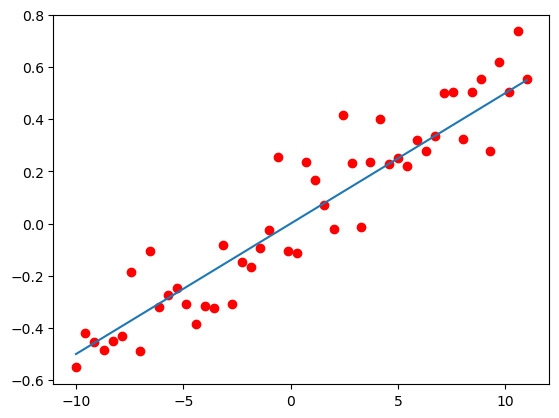

In [14]:
ax = plt.axes()
ax.scatter(x, y, c = "red")
ax.plot(x, beta*x)
plt.show()

In [15]:
# High beta, low correlation
x = np.linspace(-10, 11)
beta = 5
se = 150
error = sp.stats.norm(0, se).rvs(len(x))
y = beta * x + error
np.corrcoef(x, y)

array([[1.        , 0.16249725],
       [0.16249725, 1.        ]])

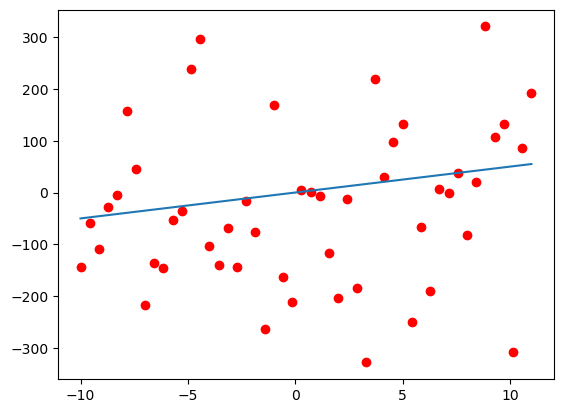

In [16]:
ax = plt.axes()
ax.scatter(x, y, c = "red")
ax.plot(x, beta*x)
plt.show()

### Answer 8

Cash is an asset example that has zero beta, but also has zero total returns.
We could consider stocks from companies whose performances are independent of market cycles, such as small-cap stocks, from strategic sectors (pharpaseuthical, energy, defence), or associated with innovation (software).

### Answer 9

I wouldn't consider the beta useful with such a small $R^2$. To support this conclusion I would check the p-value for the estimation of the beta parameter.

### Answer 10

Log returns can be added to get total returns over a desired period of time for a single asset.
Additionaly, log returns are normaly distributed, wich a fundamental property for pricing modeling.
On the other hand, log returns are not intuitive if you have to explain results and conclutions to a wider audience, and log returns cannot be as easily weigheted and added as simple returns to get total returns in a single period for a set of assests.

## Data Interpretation

### Answer 12

Although the correlation between daily returns may be high, it isn't perfect, and compounded returns represent the cumulative effects of daily returns, which means that small differences in daily returns may have a big impact when they are accumulated/compounded.

In [17]:
data = pd.read_excel("Correlation.xlsx")
data.head()

,X daily move,X compounded,Y daily move,Y compounded
0,-0.03329,0.966708,-0.03246,0.967543
1,-0.03110,0.936644,-0.02840,0.940065
2,-0.03367,0.905112,-0.02873,0.913055
3,-0.03623,0.872320,-0.03335,0.882606
4,-0.03977,0.837627,-0.03840,0.848716


In [18]:
np.corrcoef(data["X daily move"], data["Y daily move"])

array([[1.       , 0.9048011],
       [0.9048011, 1.       ]])

<AxesSubplot: >

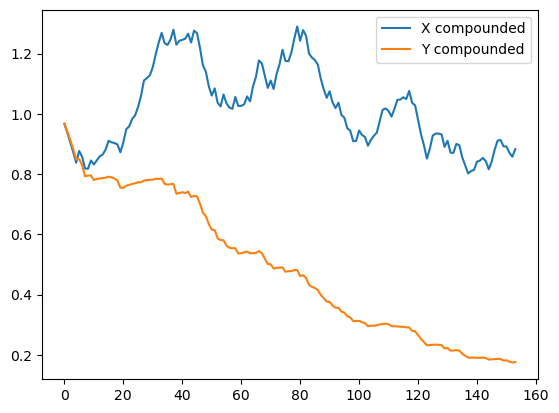

In [19]:
data[["X compounded","Y compounded"]].plot()

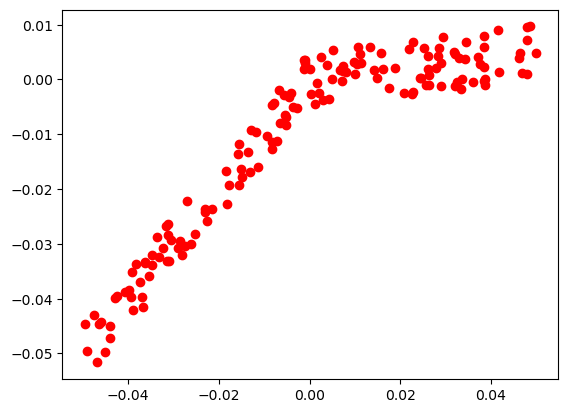

In [20]:
ax = plt.axes()
ax.scatter(data["X daily move"], data["Y daily move"], c = "red")
plt.show()

Simply using this scatterplot of daily returns should give us a good picture of what is happening.
We can see that while negative daily returns are quite similar, positive returns aren't.
This apparently small difference in the relationship between daily assets, when the series are compounded, ends up showing a huge difference in the performance. We could say that both assets have similar behavior when they fall, but when they rise, the Y asset seems to have a ceiling of 0.01 approximately. Because of this, we see in the compounded returns that when the Y asset falls, it never recovers, while the X asset does.

### Answer 13

Taking a look at the first two graphs there are two possible interpretations for the results. First, we could say, that in relative terms, the consumer-related content campaign did better, as it got a higher percentage of click-throughs over the total emails sent. However, if we were interested in absolute terms and we only wanted to know which campaign simply got the highest number of total clicks, then we should say that the business-related content campaign did better, given that 13.40% of 10928 (1464) is higher than the 14.50% of 9668 (1402).
Considering the last two graphs, we see that, relatively speaking the business-related content campaign did better for all customer spending groups. This apparently contradictory conclusion arise from the fact that the most of email from the business content campaign was sent to the relatively least successful group of customer, and the total sample is highly biased by this group for the business campaign, while the customer campaign, even with lower Click-thought rates for every group, given that the sample is more evenly distributed among the customer group, ends up with a higher total click-through rate.


## Hedging Analysis using Jupyter Notebook

In [21]:
tickers = ['TQQQ', 'QLD', '^IXIC']
data = yf.download(tickers, period="5y", interval="1d")
data = data[["Open", "Close"]]
data.head()

[*********************100%***********************]  3 of 3 completed


Open                              Close             \
                  QLD       TQQQ        ^IXIC        QLD       TQQQ   
Date                                                                  
2018-01-02  18.514999  11.741667  6937.649902  18.967501  12.153333   
2018-01-03  19.014999  12.202500  7017.069824  19.337500  12.509167   
2018-01-04  19.485001  12.655833  7089.500000  19.407499  12.582500   
2018-01-05  19.584999  12.758333  7105.740234  19.792500  12.962500   
2018-01-08  19.805000  12.960833  7135.379883  19.940001  13.106667   

                         
                  ^IXIC  
Date                     
2018-01-02  7006.899902  
2018-01-03  7065.529785  
2018-01-04  7077.910156  
2018-01-05  7136.560059  
2018-01-08  7157.390137

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Open, QLD)     1259 non-null   float64
 1   (Open, TQQQ)    1259 non-null   float64
 2   (Open, ^IXIC)   1259 non-null   float64
 3   (Close, QLD)    1259 non-null   float64
 4   (Close, TQQQ)   1259 non-null   float64
 5   (Close, ^IXIC)  1259 non-null   float64
dtypes: float64(6)
memory usage: 68.9 KB


In [23]:
log_returns = np.log(data["Close"]/data["Close"].shift(1))
log_returns["QLD-"] = log_returns["QLD"]*-1 

<AxesSubplot: xlabel='Date'>

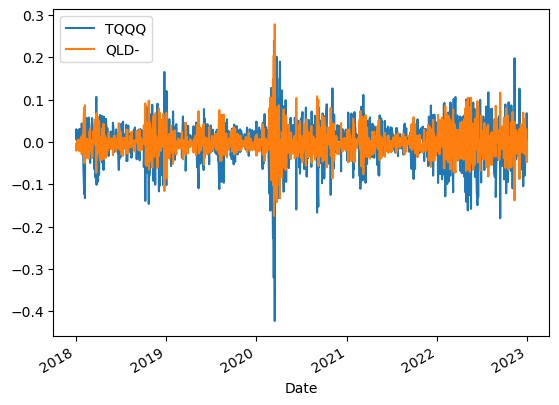

In [24]:
log_returns[["TQQQ", "QLD-"]].plot()

<AxesSubplot: xlabel='Date'>

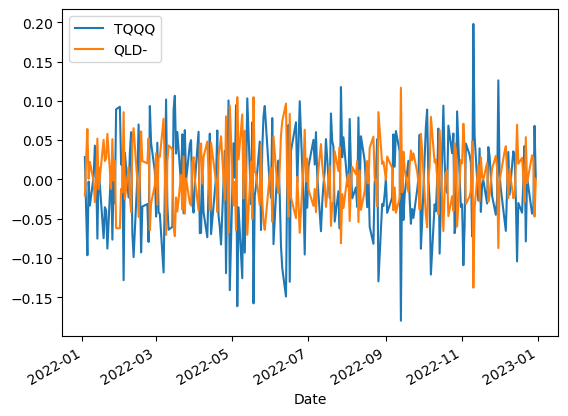

In [25]:
log_returns.loc['2022'][["TQQQ", "QLD-"]].plot()

array([[<AxesSubplot: title={'center': 'QLD'}>,
        <AxesSubplot: title={'center': 'TQQQ'}>],
       [<AxesSubplot: title={'center': '^IXIC'}>,
        <AxesSubplot: title={'center': 'QLD-'}>]], dtype=object)

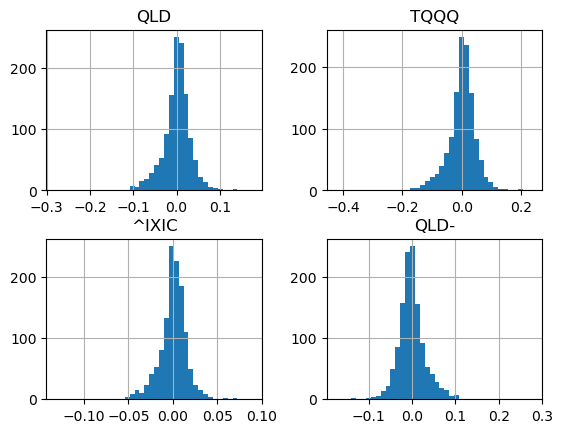

In [26]:
log_returns.hist(bins=40)

In [27]:
log_returns.mean()

QLD      0.000488
TQQQ     0.000281
^IXIC    0.000319
QLD-    -0.000488
dtype: float64

In [28]:
log_returns.cov()

,QLD,TQQQ,^IXIC,QLD-
QLD,0.001111,0.001650,0.000537,-0.001111
TQQQ,0.001650,0.002454,0.000798,-0.001650
^IXIC,0.000537,0.000798,0.000264,-0.000537
QLD-,-0.001111,-0.001650,-0.000537,0.001111


In [29]:
log_returns.corr()

,QLD,TQQQ,^IXIC,QLD-
QLD,1.000000,0.999171,0.992850,-1.000000
TQQQ,0.999171,1.000000,0.991662,-0.999171
^IXIC,0.992850,0.991662,1.000000,-0.992850
QLD-,-1.000000,-0.999171,-0.992850,1.000000
